<a href="https://colab.research.google.com/github/sahmed41/cardio_vision_ecg_multiclass/blob/main/ecg_multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Kaggle**

In [ ]:
!pip install -q kaggle

**Importing the Necessary Libraries**

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

from PIL import Image
import os
import re

**Kaggle API Connection**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahmed91","key":"c5b16cdecc09a1afd14c6eee9797b663"}'}

Importing The Dataset From Kaggle

In [ ]:
!mkdir ~/kaggle
!cp /content/kaggle.json ~/kaggle
!chmod 600 ~/kaggle/kaggle.json
!mkdir /content/dataset

In [ ]:
# Replace 'content' with the directory where 'kaggle.json' (The API file) is located
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

In [ ]:
# Downloading the dataset
!kaggle datasets download -d jayaprakashpondy/ecgimages -p /content/dataset
# Unzipping the kaggle dataset
!unzip -q /content/dataset/ecgimages.zip -d /content/dataset

 98% 281M/286M [00:10<00:00, 45.9MB/s]
100% 286M/286M [00:10<00:00, 28.7MB/s]


**Changing Folder Names to Something Simpler**

In [ ]:
import os

def rename_subfolders(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for dir_name in dirs:
            old_name = os.path.join(root, dir_name)
            new_name = os.path.join(root, dir_name)  # Rename the subfolder here
            if old_name == '/content/dataset/train/Normal Person ECG Images (284x12=3408)':
              new_name = os.path.join(root, "normal")
            elif old_name == '/content/dataset/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)':
              new_name = os.path.join(root, "abnormal heartbeat")
            elif old_name == '/content/dataset/train/ECG Images of Patient that have History of MI (172x12=2064)':
              new_name = os.path.join(root, "history_of_mi")
            elif old_name == '/content/dataset/train/ECG Images of Myocardial Infarction Patients (240x12=2880)':
              new_name = os.path.join(root, "myocardial_infarction")
            elif old_name == '/content/dataset/test/Normal Person ECG Images (284x12=3408)':
              new_name = os.path.join(root, "normal")
            elif old_name == '/content/dataset/test/ECG Images of Patient that have abnormal heartbeat (233x12=2796)':
              new_name = os.path.join(root, "abnormal heartbeat")
            elif old_name == '/content/dataset/test/ECG Images of Patient that have History of MI (172x12=2064)':
              new_name = os.path.join(root, "history_of_mi")
            elif old_name == '/content/dataset/test/ECG Images of Myocardial Infarction Patients (240x12=2880)':
              new_name = os.path.join(root, "myocardial_infarction")

            os.rename(old_name, new_name)
            print(new_name)

# Example usage
# folder_path = '/content/dataset/test'
rename_subfolders('/content/dataset/train')
rename_subfolders('/content/dataset/test')


/content/dataset/train/abnormal heartbeat
/content/dataset/train/history_of_mi
/content/dataset/train/myocardial_infarction
/content/dataset/train/normal
/content/dataset/test/abnormal heartbeat
/content/dataset/test/history_of_mi
/content/dataset/test/myocardial_infarction
/content/dataset/test/normal


**Preparing the Data For Training**

In [ ]:
# Define data paths
train_data_dir = '/content/dataset/train'
valid_data_dir = '/content/dataset/test'

# Define image parameters
img_width, img_height = 100, 71
batch_size = 32 # Hyperparameter

In [ ]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load the data using the generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # For binary classification, use 'categorical' for multiclass
)

validation_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # For binary classification, use 'categorical' for multiclass
)

Found 928 images belonging to 4 classes.
Found 448 images belonging to 4 classes.


In [ ]:
training_images, training_labels = next(train_generator)
test_images, test_labels = next(validation_generator)
print("Shape of images batch:", training_images.shape)
print("Shape of labels batch:", training_labels.shape)

Shape of images batch: (32, 100, 71, 3)
Shape of labels batch: (32, 4)


In [ ]:
# Load a pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add your custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(list(train_generator.class_indices.keys())), activation='sigmoid')(x)  # For multi-label classification

# Create the final model for training
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to avoid changing their weights during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss function and metrics for multi-label classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the generators
epochs = 10  # Choose an appropriate number of epochs

training = model.fit(
    train_generator,
    steps_per_epoch=928 // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=448 // batch_size
)


Epoch 1/10
29/29 [==============================] - 183s 6s/step - loss: 0.5917 - accuracy: 0.3060 - val_loss: 0.5492 - val_accuracy: 0.4442
Epoch 2/10
29/29 [==============================] - 143s 5s/step - loss: 0.5316 - accuracy: 0.4256 - val_loss: 0.5366 - val_accuracy: 0.3326
Epoch 3/10
29/29 [==============================] - 178s 6s/step - loss: 0.5184 - accuracy: 0.4278 - val_loss: 0.5217 - val_accuracy: 0.4040
Epoch 4/10
29/29 [==============================] - 144s 5s/step - loss: 0.4983 - accuracy: 0.4989 - val_loss: 0.5058 - val_accuracy: 0.4375
Epoch 5/10
29/29 [==============================] - 179s 6s/step - loss: 0.4895 - accuracy: 0.5086 - val_loss: 0.4903 - val_accuracy: 0.5402
Epoch 6/10
29/29 [==============================] - 181s 6s/step - loss: 0.4828 - accuracy: 0.4978 - val_loss: 0.4837 - val_accuracy: 0.4688
Epoch 7/10
29/29 [==============================] - 180s 6s/step - loss: 0.4771 - accuracy: 0.5151 - val_loss: 0.4704 - val_accuracy: 0.5290
Epoch 8/10
29

**Accuracy Graph**

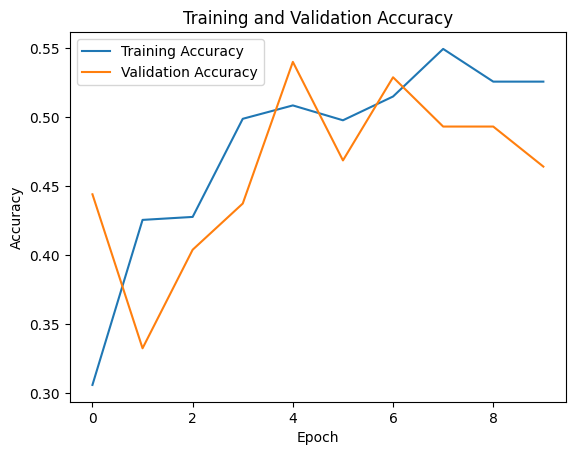

In [ ]:
training_accuracy = training.history['accuracy']
validation_accuracy = training.history['val_accuracy']

plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

**Loss Graph**

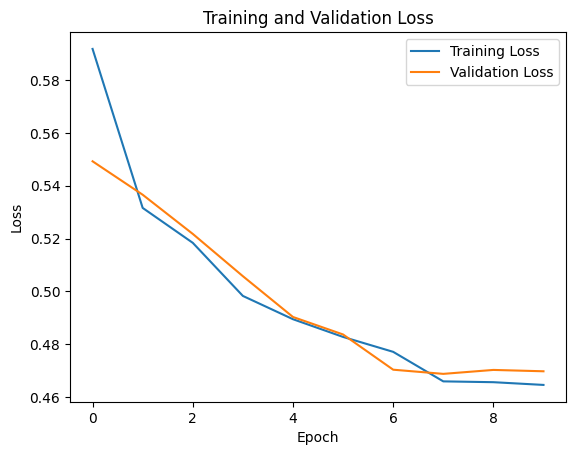

In [ ]:
training_loss = training.history['loss']
validation_loss = training.history['val_loss']

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Precision and Recall Curve**

14/14 [==============================] - 46s 3s/step
Precision per class: [0.18867925 0.3125     0.27272727 0.26217228]
Recall per class: [0.17857143 0.17857143 0.02678571 0.625     ]
Macro-Averaged Precision: 0.25901970066362157
Macro-Averaged Recall: 0.25223214285714285
Confusion Matrix:
 [[20 15  4 73]
 [28 20  2 62]
 [33 14  3 62]
 [25 15  2 70]]


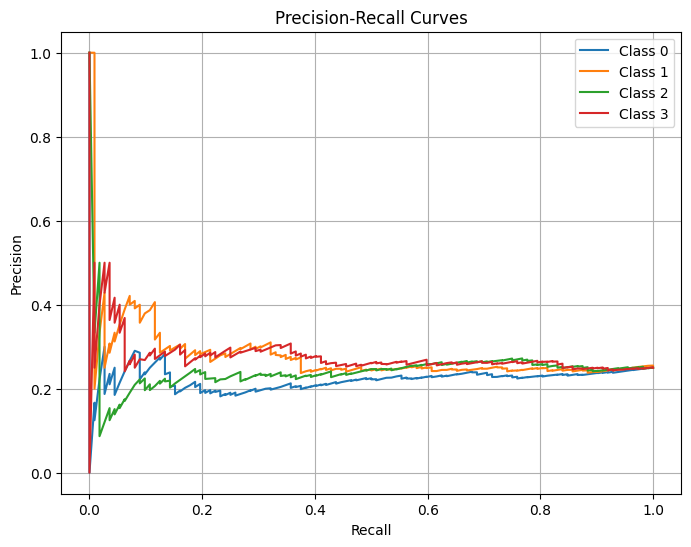

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Make predictions on validation data
predictions = model.predict(validation_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation generator
true_labels = validation_generator.classes

# Calculate precision and recall for each class
precision_per_class = precision_score(true_labels, predicted_labels, average=None)
recall_per_class = recall_score(true_labels, predicted_labels, average=None)

# Calculate overall precision and recall
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the results
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("Macro-Averaged Precision:", precision_macro)
print("Macro-Averaged Recall:", recall_macro)
print("Confusion Matrix:\n", conf_matrix)

# Create precision-recall curve for each class (assuming binary classification for each class)
plt.figure(figsize=(8, 6))
for class_idx in range(4):
    precision_curve, recall_curve, _ = precision_recall_curve(
        true_labels == class_idx, predictions[:, class_idx]
    )
    plt.plot(recall_curve, precision_curve, label=f'Class {class_idx}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid()
plt.show()

**Specificity Graph**

Specificity per class: [0.7440476168331916, 0.8690476164611678, 0.9761904732851474, 0.41369047495925454]
Macro-Averaged Specificity: 0.7507440453846903


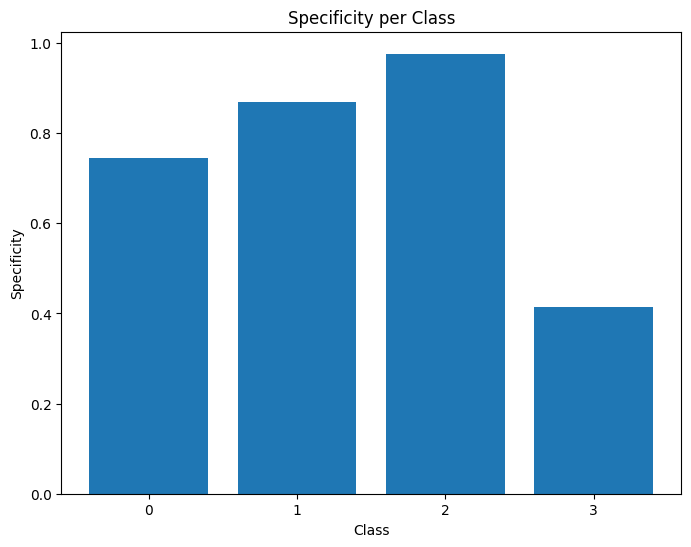

In [ ]:
class_labels = list(train_generator.class_indices.keys())

# Calculate specificity for each class
def specificity(y_true, y_pred):
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    total_negatives = np.sum(y_true == 0)
    return true_negatives / (total_negatives + 1e-6)

specificity_per_class = [specificity(true_labels == class_idx, predicted_labels == class_idx) for class_idx in range(len(class_labels))]

# Calculate overall specificity
macro_specificity = np.mean(specificity_per_class)

# Print the results
print("Specificity per class:", specificity_per_class)
print("Macro-Averaged Specificity:", macro_specificity)

# Plot the specificity for each class
plt.figure(figsize=(8, 6))
plt.bar(range(len(class_labels)), specificity_per_class, tick_label=range(len(class_labels)))
plt.xlabel('Class')
plt.ylabel('Specificity')
plt.title('Specificity per Class')
plt.show()

**Saving the Model**

In [ ]:
model.save('/content/Model/ecg_multilabel_model.h5')

**Testing The Model**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define the path to your test data folder
# test_data_dir = 'path/to/test_data_folder'

# Set the batch size for the test data generator
batch_size = 32  # Choose an appropriate batch size based on your system's memory and GPU capacity

# Create a test data generator with normalization but without data augmentation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to maintain the order of images for evaluation
)

Found 448 images belonging to 4 classes.


In [ ]:
from keras.models import load_model

# Load the saved model
model = load_model('/content/Model/ecg_multilabel_model.h5')

# Assuming you have a test_generator for generating test data, similar to train_generator and validation_generator
num_test_samples = len(test_generator.filenames)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=num_test_samples // batch_size)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


<ipython-input-24-df9d2343f757>:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=num_test_samples // batch_size)


Test Loss: 0.46977391839027405
Test Accuracy: 0.4642857015132904


In [ ]:
# Assuming you have already trained and saved the model

# Load the trained model
from tensorflow.keras.models import load_model

model = load_model('/content/Model/ecg_multilabel_model.h5')

# Assuming you have a test dataset for prediction
# Load and preprocess the test data

# Make predictions on the test data
predictions = model.predict(test_generator)

# Assuming you have a threshold for deciding the label predictions
threshold = 0.5

# Convert the predicted probabilities to binary labels based on the threshold
binary_predictions = (predictions > threshold).astype(int)

# Assuming you have a list of label names
label_names = list(train_generator.class_indices.keys())

# Print the predicted labels for each sample
for i in range(len(test_generator)):
    predicted_labels = [label_names[j] for j in range(len(label_names)) if binary_predictions[i][j] == 1]
    print(f"Sample {i+1}: Predicted Labels: {predicted_labels}")


14/14 [==============================] - 44s 3s/step
Sample 1: Predicted Labels: []
Sample 2: Predicted Labels: ['abnormal heartbeat']
Sample 3: Predicted Labels: []
Sample 4: Predicted Labels: []
Sample 5: Predicted Labels: ['abnormal heartbeat']
Sample 6: Predicted Labels: []
Sample 7: Predicted Labels: []
Sample 8: Predicted Labels: ['abnormal heartbeat']
Sample 9: Predicted Labels: ['abnormal heartbeat']
Sample 10: Predicted Labels: ['normal']
Sample 11: Predicted Labels: ['abnormal heartbeat', 'history_of_mi']
Sample 12: Predicted Labels: []
Sample 13: Predicted Labels: []
Sample 14: Predicted Labels: ['abnormal heartbeat']


In [ ]:
print(train_generator)
print(class_labels)

['abnormal heartbeat', 'history_of_mi', 'myocardial_infarction', 'normal']


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Assuming you have a single file path
file_path = '/content/dataset/train/normal/Normal(10).jpg'

# Load and preprocess the file data
img = image.load_img(file_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make prediction on the preprocessed image
prediction = model.predict(img_array)

# Assuming you have a list of label names
label_names = ['abnormal heartbeat', 'history_of_mi', 'myocardial_infarction', 'normal']

# Calculate the percentages of labels
label_percentages = (prediction[0] * 100).tolist()

# Print the label names and their corresponding percentages
for label, percentage in zip(label_names, label_percentages):
    print(f"{label}: {percentage}%")


1/1 [==============================] - 0s 429ms/step
abnormal heartbeat: 100.0%
history_of_mi: 100.0%
myocardial_infarction: 0.0%
normal: 0.0%
